# Transformer for turbofan dataset

The main ideas for preprocessing and data handling were taken from the paper: Domain-Adaptive Remaining Useful Life Prediction with Transformer.

Initially, we attempted to generate the Transformer model with the discriminator components described in the paper, but it proved to be too complicated the develop and to train (for the time given). Ultimately, we developed a simple Transformer encoder for predicting the Remaining Useful Life (RUL), which serves as our baseline model. Additionally, we implemented an encoder-decoder Transformer for predicting RUL. We performed a manual hyperparameter tuning, do to the fact that a grid search is to slow for the models. We use the same hyperparameters to train every model.

The results were not satisfactory, likely because the model was too simple. However, increasing the model's complexity would require significantly more training time and coding effort. Although tuning hyperparameters can improve the final RMSE results on the training set, conducting a grid search was too slow. Therefore, we opted for manual (random) hyperparameter tuning.

# 0. Imports and data

## 0.1 Import libraries

In [1]:
!pip install mrmr_selection
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import math
import pandas as pd
import numpy as np
import IPython
from mrmr import mrmr_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage
set_seed(0)

## 0.2 Load data

In [4]:
turbine1_train = pd.read_csv('./data/train_FD001.txt', sep='\s+', header=None)
turbine1_test = pd.read_csv('./data/test_FD001.txt', sep='\s+', header=None)
turbine2_train = pd.read_csv('./data/train_FD002.txt', sep='\s+', header=None)
turbine2_test = pd.read_csv('./data/test_FD002.txt', sep='\s+', header=None)
turbine3_train = pd.read_csv('./data/train_FD003.txt', sep='\s+', header=None)
turbine3_test = pd.read_csv('./data/test_FD003.txt', sep='\s+', header=None)
turbine4_train = pd.read_csv('./data/train_FD004.txt', sep='\s+', header=None)
turbine4_test = pd.read_csv('./data/test_FD004.txt', sep='\s+', header=None)

turbine1_rul_test = pd.read_csv('./data/RUL_FD001.txt',sep='\s+', header=None, names=["RUL"])
turbine2_rul_test = pd.read_csv('./data/RUL_FD002.txt',sep='\s+', header=None, names=["RUL"])
turbine3_rul_test = pd.read_csv('./data/RUL_FD003.txt',sep='\s+', header=None, names=["RUL"])
turbine4_rul_test = pd.read_csv('./data/RUL_FD004.txt',sep='\s+', header=None, names=["RUL"])

In [5]:
# Define column names
index_columns_names =  ["unitn","cycle"]
operational_settings_columns_names = ["os_"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["sm_"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

In [6]:
turbine1_train.columns = input_file_column_names
turbine1_test.columns = input_file_column_names
turbine2_train.columns = input_file_column_names
turbine2_test.columns = input_file_column_names
turbine3_train.columns = input_file_column_names
turbine3_test.columns = input_file_column_names
turbine4_train.columns = input_file_column_names
turbine4_test.columns = input_file_column_names

In [7]:
# Add RUL column to the dataframes
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unitn")
    max_cycle = grouped_by_unit["cycle"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unitn', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["RUL"] = remaining_useful_life
    result_frame.drop("max_cycle", axis=1, inplace=True)
    return result_frame

#Only for train data. Test data we dont have max_cycle
turbine1_train = add_remaining_useful_life(turbine1_train)
turbine2_train = add_remaining_useful_life(turbine2_train)
turbine3_train = add_remaining_useful_life(turbine3_train)
turbine4_train = add_remaining_useful_life(turbine4_train)

# 1. Process data function

In [8]:
def normalize_data(df, features):
    """
    Normalize the data using min-max normalization for each feature.
    Idea from: Domain-Adaptive-Remaining-Useful-Life-Prediction-with-Transformer
    
    Parameters:
    - df: DataFrame containing the data.
    - features: List of feature names to normalize.
    
    Returns:
    - df: Normalized DataFrame.
    """
    # scaler = MinMaxScaler()
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

def piecewise_rul(df, max_rul=130):
    """
    Apply piecewise RUL function.
    Idea from: Domain-Adaptive-Remaining-Useful-Life-Prediction-with-Transformer

    Parameters:
    - df: DataFrame containing the data.
    - max_rul: Maximum RUL value.
    
    Returns:
    - df: DataFrame with updated RUL.
    """
    df['RUL'] = np.minimum(df['RUL'], max_rul)
    return df

def generate_padded_sequences(df, window_size, features, rul_col='RUL', verbose=True):
    """
    Generate sliding window sequences with padding.
    Idea from: Domain-Adaptive-Remaining-Useful-Life-Prediction-with-Transformer
    
    Parameters:
    - df: DataFrame containing the data.
    - window_size: Size of the sliding window.
    - features: List of feature names.
    - rul_col: Name of the RUL column.
    
    Returns:
    - features_array: Numpy array of features sequences.
    - labels_array: Numpy array of corresponding RUL labels.
    """
    sequences = []
    labels = []
    
    grouped = df.groupby('unitn')
    
    for unit, group in grouped:
        num_cycles = group['cycle'].max()
        sensor_data = group[features].values
        rul = group[rul_col].values
        
        for i in range(1, num_cycles + 1):
            window = []
            for k in range(i - window_size + 1, i + 1):
                if k < 1:
                    window.append(np.ones(len(features)))  # Pad with ones
                elif k > num_cycles:
                    window.append(np.zeros(len(features)))  # Pad with zeros
                else:
                    window.append(sensor_data[k - 1])
            sequences.append(window)
            # labels.append(rul[min(i, num_cycles) - 1])
            labels.append(rul[min(i + window_size - 1, num_cycles) - 1])
    
    features_array = np.array(sequences)
    labels_array = np.array(labels).reshape(-1, 1)
    if verbose:
        print("features with shape {}".format(features_array.shape))
        print("labels with shape {}".format(labels_array.shape))
    return features_array, labels_array

# Function to find features
def mrmr_feature_selection(X, y):
    X = X.drop(columns=['unitn', 'cycle']) 
    selected_features = mrmr_regression(X=X, y=y, K=10)
    return selected_features

# Example usage
# Define features and target column
sensor_features = turbine1_train.columns.difference(['unitn', 'cycle', 'RUL']).tolist()
rul_column = 'RUL'

# Normalize the data
df = normalize_data(turbine1_train, sensor_features)

# Apply piecewise RUL function
df = piecewise_rul(df, max_rul=130)

# Generate padded sequences
window_size = 70
X_train, y_train = generate_padded_sequences(df, window_size, sensor_features, rul_column)

features with shape (20631, 70, 24)
labels with shape (20631, 1)


In [9]:
def split_train_val(df_train, window_size, batch_size, sensor_features, rul_column):
    # Replace missing reading with one (paper)
    # df_train = df_train.fillna(1, inplace=True) 
    
    # Use 80/20 for train validation
    grouped = df_train.groupby('unitn')
    unitn_values = df_train['unitn'].unique()
    
    # Split unitn values into training and validation
    unitn_train, unitn_val = train_test_split(unitn_values, test_size=0.2, random_state=42)
    
    # Select rows for training and validation based on unitn
    train_data = pd.concat([grouped.get_group(unit) for unit in unitn_train])
    val_data = pd.concat([grouped.get_group(unit) for unit in unitn_val])
    
    # Pipeline data cleaning
    train_data = normalize_data(train_data, sensor_features) # Normalize the data
    train_data = piecewise_rul(train_data, max_rul=130) # Apply piecewise RUL function
    X_train, y_train = generate_padded_sequences(train_data, window_size, sensor_features, rul_column) # Generate padded sequences
    val_data = normalize_data(val_data, sensor_features) # Normalize the data
    val_data = piecewise_rul(val_data, max_rul=130) # Apply piecewise RUL function
    X_val, y_val = generate_padded_sequences(val_data, window_size, sensor_features, rul_column) # Generate padded sequences
    
    # Convert X_train, y_train, X_val, and y_val to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    
    # Labels must have [batch,labels_dim] dimention
    y_train_tensor = y_train_tensor.unsqueeze(1)
    y_val_tensor = y_val_tensor.unsqueeze(1)
    
    # Create DataLoaders for training and validation
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# 2. Models function

## 2.1 Model definition

In [10]:
# Define mymodel
class OnlyEncoder(nn.Module):
    def __init__(self, d_model=24, dropout=0.1, nhead=8, nlayers=2, max_len=500) -> None:
        super().__init__()
        self.max_len = max_len
        self.model_type = 'Transformer'
        # self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout, max_len=max_len)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(d_model, 1)
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, attn_msk=None) -> torch.Tensor:
        # src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output1 = self.transformer_encoder(src, attn_msk)
        output1 = self.dropout(output1)
        output2 = self.decoder(output1[:, -1, :]) #last output
        return output2

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
        
class TransformerModel(nn.Module):
    def __init__(self, d_model=24, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, max_len=500):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout, max_len=max_len)
        # self.embedding = nn.Linear(input_size, d_model)
        self.transformer_encoder = TransformerEncoder(TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True), num_encoder_layers)
        self.transformer_decoder = TransformerDecoder(TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True), num_decoder_layers)
        self.fc_out = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(src, memory)
        output = self.dropout(output)
        output = self.fc_out(output[:, -1, :])
        return output

## 2.2 Loss function

In [11]:
# Function to calculate RMSE
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets)**2))

class CustomScoreLoss(nn.Module):
    def __init__(self):
        super(CustomScoreLoss, self).__init__()

    def forward(self, y_pred, y_true):
        # Calculate the difference
        diff = y_pred - y_true

        # Apply the exponential penalties
        loss = torch.where(diff >= 0,
                           torch.exp(diff / 10) - 1,
                           torch.exp(-diff / 13) - 1)
        
        # Return the mean loss over the batch
        return loss.mean()

## 2.3 Train and inference function

In [12]:
# Train function
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, patience=None, model_path='best_model.pth'):
    best_val_loss = float('inf')
    patience_count = 0
    prev_lr = optimizer.param_groups[0]['lr']
    final_loss_train=[]
    final_rmse_train=[]
    final_loss_val=[]
    final_rmse_val=[]
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_rmse = 0

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            prediction = model(batch_features)
            prediction = prediction.squeeze()
            batch_labels = batch_labels.squeeze()
            loss = criterion(prediction, batch_labels)
            rmse_value = rmse(prediction, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_rmse += rmse_value.item()

        avg_loss = total_loss / len(train_loader)
        avg_rmse = total_rmse / len(train_loader)
        final_loss_train.append(avg_loss)
        final_rmse_train.append(avg_rmse)
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < prev_lr:
            print(f"Learning rate has been reduced to {current_lr}")
        prev_lr = current_lr
        
        model.eval()
        val_loss = 0
        val_rmse = 0
        with torch.no_grad():
            for val_batch_features, val_batch_labels in val_loader:
                val_batch_features = val_batch_features.to(device)
                val_batch_labels = val_batch_labels.to(device)
                val_prediction = model(val_batch_features)
                val_prediction = val_prediction.squeeze()
                val_batch_labels = val_batch_labels.squeeze()
                val_loss += criterion(val_prediction, val_batch_labels).item()
                val_rmse += rmse(val_prediction, val_batch_labels).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_rmse = val_rmse / len(val_loader)
        final_loss_val.append(avg_val_loss)
        final_rmse_val.append(avg_val_rmse)
        print(f"Epoch {epoch+1} || Train Loss: {round(avg_loss,2)}, Train RMSE: {round(avg_rmse,2)} || Validation Loss: {round(avg_val_loss,2)}, Validation RMSE: {round(avg_val_rmse,2)}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)  
            patience_count = 0
        else:
            if patience is not None:
                patience_count += 1
                if patience_count >= patience:
                    print("Early stopping: Validation loss did not improve for {} epochs".format(patience))
                    break
    return (final_loss_train, final_rmse_train), (final_loss_val, final_rmse_val)

# Inference function
def inference(model, test_data, label, window_size, sensor_features):
    # Group the dataframe by motor ID
    grouped = test_data.groupby('unitn')
    # Count loss
    total_loss = 0
    total_rmse = 0
    predictions = []
    true_labels = []
    # Predict for each test sequence
    t0 = time.time()
    model.eval()
    for motor_id, group_df in grouped: 
        # Process sequence
        X_test, y_test_fake = generate_padded_sequences(group_df, window_size, sensor_features, verbose=False) # Generate padded sequences
        window = X_test[-1]
        window = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        prediction = model(window).squeeze()
        # window = torch.tensor(X_test, dtype=torch.float32)
        # prediction = model.forward(window)
        # prediction = prediction[-1]
        true_label = torch.tensor(label.iloc[motor_id-1], dtype=torch.float32).squeeze()
        predictions.append(prediction.detach().item())
        true_labels.append(true_label.detach().item())
        # Compute the loss
        loss = criterion(prediction, true_label)
        rmse_value = rmse(prediction, true_label)
        
        total_loss += loss.item()
        total_rmse += rmse_value.item()
    # Print the average loss and RMSE for the epoch
    avg_loss = total_loss / len(grouped)
    avg_rmse = total_rmse / len(grouped)

    print(f"Test loss: {avg_loss}, Test RMSE: {avg_rmse}")
    print(f"Total time in testing {time.time()-t0}")
    return predictions, true_labels

## 2.4 Hyperparameter settings and dataset

In [13]:
# Hyperparameters Encoder from paper
# d_model = 128  # This is the hidden size (can be 128, as per your alternative suggestion) # see if we need to elimnate the embeding layer
dropout = 0.1
nhead = 8 # Number of heads in the multi-head attention mechanism
nlayers = 2  # Number of Transformer layers
max_len = 500  # Maximum sequence length (useful for positional encoding)
window_size = 70  # Assuming this is for sequence windowing
batch_size = 128  # Batch size for training paper=128. We have smaller model => 64
num_epochs = 100  # Number of epochs for training
learning_rate = 0.001 # Initial learning rate paper = 0.02 (model bigger)
patience = None # No early stopping
step_size = 30 # For lr droping

# Hyperparameters Transformer
# d_model = 128  # This is the hidden size (can be 128, as per your alternative suggestion) # see if we need to elimnate the embeding layer
# Same dropout, nhead, max, len, batch size, everything. But we add num_encoder and num_decoder layes.
num_encoder_layers=2
num_decoder_layers=2
dim_feedforward=512

# Loss and Opti
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01) # We introduce weight decay becase model can diverge with 0.02 lr. Paper use SGD, but we need probabilities for that.
criterion = CustomScoreLoss() # In paper they use BCE, but the model use Discriminators.
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) # From paper
# criterion = nn.MSELoss()

# Data
# They use all features to the model. => for all data
sensor_features = turbine1_train.columns.difference(['unitn', 'cycle', 'RUL']).tolist()
rul_column = 'RUL'

# Test
turbine1_test = add_remaining_useful_life(turbine1_test)
turbine1_test = normalize_data(turbine1_test, sensor_features)
turbine2_test = add_remaining_useful_life(turbine2_test)
turbine2_test = normalize_data(turbine2_test, sensor_features)
turbine3_test = add_remaining_useful_life(turbine3_test)
turbine3_test = normalize_data(turbine3_test, sensor_features)
turbine4_test = add_remaining_useful_life(turbine4_test)
turbine4_test = normalize_data(turbine4_test, sensor_features)

# Dataloaders
train_loader_t1, val_loader_t1 = split_train_val(turbine1_train, window_size=window_size, batch_size=batch_size, sensor_features=sensor_features, rul_column=rul_column)
train_loader_t2, val_loader_t2 = split_train_val(turbine2_train, window_size=window_size, batch_size=batch_size, sensor_features=sensor_features, rul_column=rul_column)
train_loader_t3, val_loader_t3 = split_train_val(turbine3_train, window_size=window_size, batch_size=batch_size, sensor_features=sensor_features, rul_column=rul_column)
train_loader_t4, val_loader_t4 = split_train_val(turbine4_train, window_size=window_size, batch_size=batch_size, sensor_features=sensor_features, rul_column=rul_column)

features with shape (16561, 70, 24)
labels with shape (16561, 1)
features with shape (4070, 70, 24)
labels with shape (4070, 1)
features with shape (43464, 70, 24)
labels with shape (43464, 1)
features with shape (10295, 70, 24)
labels with shape (10295, 1)
features with shape (20012, 70, 24)
labels with shape (20012, 1)
features with shape (4708, 70, 24)
labels with shape (4708, 1)
features with shape (49294, 70, 24)
labels with shape (49294, 1)
features with shape (11955, 70, 24)
labels with shape (11955, 1)


# 3. Turbine 1

## 3.1 Encoder

In [14]:
# Initialize the model
model = OnlyEncoder(d_model=24, dropout=dropout, nhead=nhead, nlayers=nlayers, max_len=max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) # From paper
# Train the model
loss_train_encoder_t1, loss_val_encoder_t1 = train_model(model, train_loader_t1, val_loader_t1, optimizer, criterion, scheduler, num_epochs, patience=patience, model_path='encoder_t1_best_model.pth')

Epoch 1 || Train Loss: 2585.38, Train RMSE: 59.79 || Validation Loss: 2277.54, Validation RMSE: 58.08
Epoch 2 || Train Loss: 2089.78, Train RMSE: 57.97 || Validation Loss: 1807.6, Validation RMSE: 56.18
Epoch 3 || Train Loss: 1616.24, Train RMSE: 55.88 || Validation Loss: 1376.42, Validation RMSE: 54.13
Epoch 4 || Train Loss: 1225.28, Train RMSE: 53.78 || Validation Loss: 1034.47, Validation RMSE: 52.21
Epoch 5 || Train Loss: 923.81, Train RMSE: 51.85 || Validation Loss: 779.64, Validation RMSE: 50.55
Epoch 6 || Train Loss: 701.09, Train RMSE: 50.2 || Validation Loss: 594.76, Validation RMSE: 49.19
Epoch 7 || Train Loss: 538.95, Train RMSE: 48.84 || Validation Loss: 461.98, Validation RMSE: 48.11
Epoch 8 || Train Loss: 421.14, Train RMSE: 47.78 || Validation Loss: 364.89, Validation RMSE: 47.29
Epoch 9 || Train Loss: 339.77, Train RMSE: 47.02 || Validation Loss: 294.3, Validation RMSE: 46.69
Epoch 10 || Train Loss: 279.07, Train RMSE: 46.46 || Validation Loss: 242.34, Validation RMSE: 

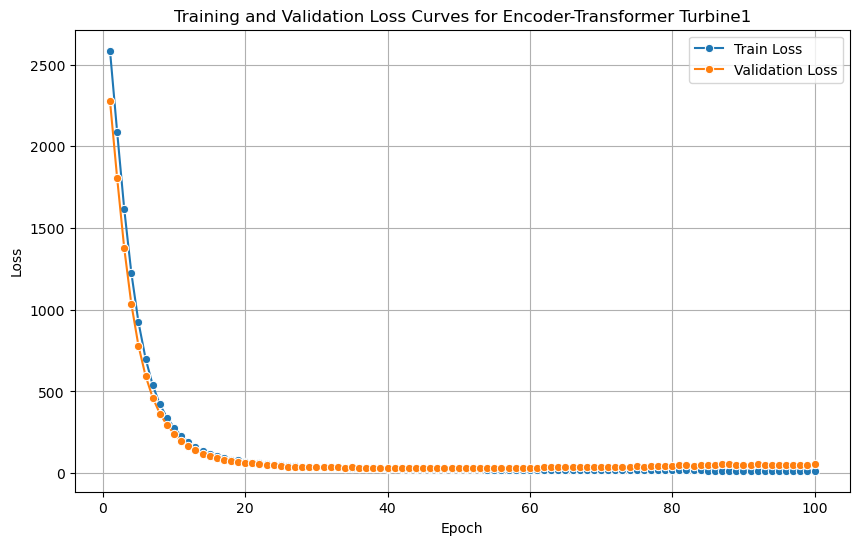

In [15]:
# Plot training
epochs = range(1, len(loss_train_encoder_t1[0]) + 1)

train_loss_df = pd.DataFrame({'Epoch': epochs, 'Train Loss': loss_train_encoder_t1[0]})
val_loss_df = pd.DataFrame({'Epoch': epochs, 'Val Loss': loss_val_encoder_t1[0]})

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_df, x='Epoch', y='Train Loss', marker='o', label='Train Loss')
sns.lineplot(data=val_loss_df, x='Epoch', y='Val Loss', marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Encoder-Transformer Turbine1')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Evaluate the model, load the best model
model = OnlyEncoder(d_model=24, dropout=dropout, nhead=nhead, nlayers=nlayers, max_len=max_len)
best_model_state_dict = torch.load('encoder_t1_best_model.pth')
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [17]:
pred_encoder_t1, true_encoder_t1 = inference(model, turbine1_test, turbine1_rul_test, window_size, sensor_features)

Test loss: 824.390414955616, Test RMSE: 59.505015478134155
Total time in testing 4.738560676574707


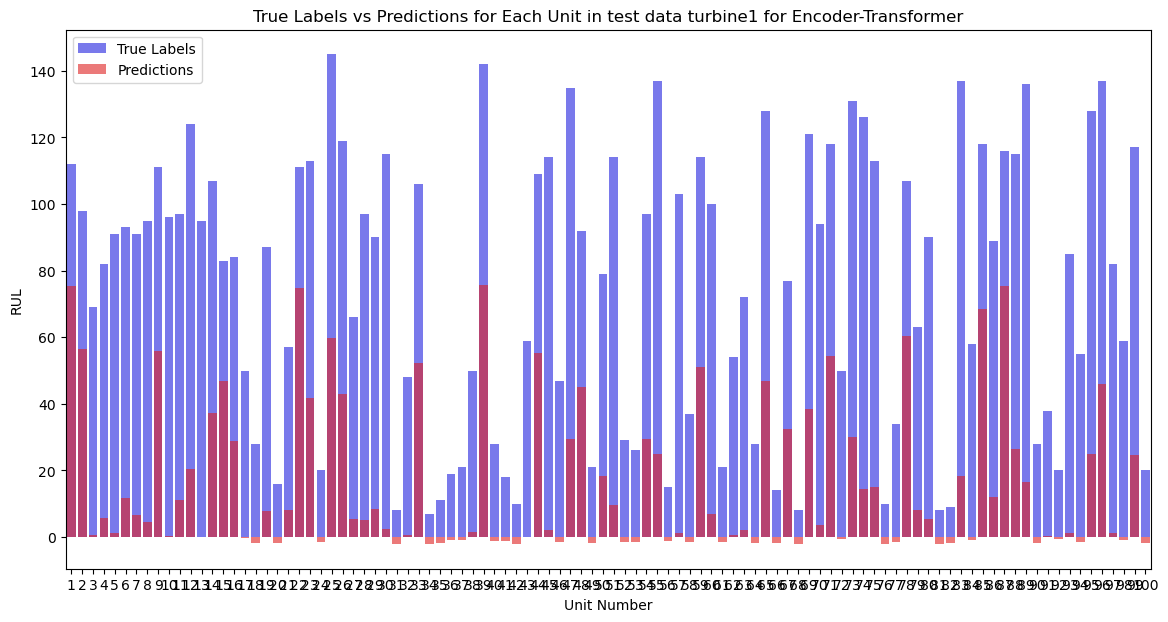

In [18]:
# Plot predictions vs true labels
units = range(1, len(pred_encoder_t1) + 1)
t_df = pd.DataFrame({'Unit': units, 'True Label': true_encoder_t1})
p_df = pd.DataFrame({'Unit': units, 'Prediction': pred_encoder_t1})

plt.figure(figsize=(14, 7))
sns.barplot(x='Unit', y='True Label', data=t_df, color='blue', alpha=0.6, label='True Labels')
sns.barplot(x='Unit', y='Prediction', data=p_df, color='red', alpha=0.6, label='Predictions')
plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('True Labels vs Predictions for Each Unit in test data turbine1 for Encoder-Transformer')
plt.legend()
plt.show()

## 3.2 Encoder-Decoder

In [19]:
# Initialize the model
model = TransformerModel(d_model=24, dropout=dropout, nhead=nhead, num_encoder_layers=num_encoder_layers, 
                         num_decoder_layers=num_decoder_layers, max_len=max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) # From paper
# Train the model
loss_train_trans_t1, loss_val_trans_t1 = train_model(model, train_loader_t1, val_loader_t1, optimizer, criterion, scheduler, num_epochs, patience=patience, model_path='transformer_t1_best_model.pth')

Epoch 1 || Train Loss: 2205.98, Train RMSE: 58.38 || Validation Loss: 1914.28, Validation RMSE: 56.64
Epoch 2 || Train Loss: 1758.54, Train RMSE: 56.53 || Validation Loss: 1517.68, Validation RMSE: 54.84
Epoch 3 || Train Loss: 1367.89, Train RMSE: 54.59 || Validation Loss: 1167.18, Validation RMSE: 52.99
Epoch 4 || Train Loss: 1036.9, Train RMSE: 52.63 || Validation Loss: 879.46, Validation RMSE: 51.23
Epoch 5 || Train Loss: 784.24, Train RMSE: 50.86 || Validation Loss: 664.09, Validation RMSE: 49.72
Epoch 6 || Train Loss: 595.96, Train RMSE: 49.33 || Validation Loss: 506.66, Validation RMSE: 48.49
Epoch 7 || Train Loss: 459.28, Train RMSE: 48.14 || Validation Loss: 392.35, Validation RMSE: 47.53
Epoch 8 || Train Loss: 360.66, Train RMSE: 47.23 || Validation Loss: 310.76, Validation RMSE: 46.83
Epoch 9 || Train Loss: 288.68, Train RMSE: 46.55 || Validation Loss: 252.63, Validation RMSE: 46.35
Epoch 10 || Train Loss: 239.24, Train RMSE: 46.13 || Validation Loss: 209.86, Validation RMSE:

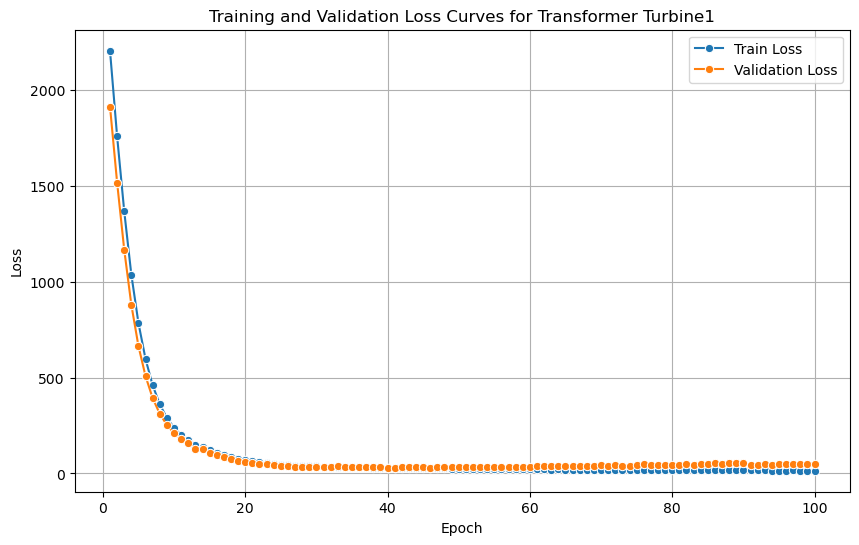

In [20]:
# Plot training
epochs = range(1, len(loss_train_trans_t1[0]) + 1)

train_loss_df = pd.DataFrame({'Epoch': epochs, 'Train Loss': loss_train_trans_t1[0]})
val_loss_df = pd.DataFrame({'Epoch': epochs, 'Val Loss': loss_val_trans_t1[0]})

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_df, x='Epoch', y='Train Loss', marker='o', label='Train Loss')
sns.lineplot(data=val_loss_df, x='Epoch', y='Val Loss', marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Transformer Turbine1')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Evaluate the model
model = TransformerModel(d_model=24, dropout=dropout, nhead=nhead, 
                         num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, max_len=max_len)
best_model_state_dict = torch.load('transformer_t1_best_model.pth')
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [22]:
pred_trans_t1, true_trans_t1 = inference(model, turbine1_test, turbine1_rul_test, window_size, sensor_features)

Test loss: 1232.1489992189408, Test RMSE: 61.25406632900238
Total time in testing 7.5281665325164795


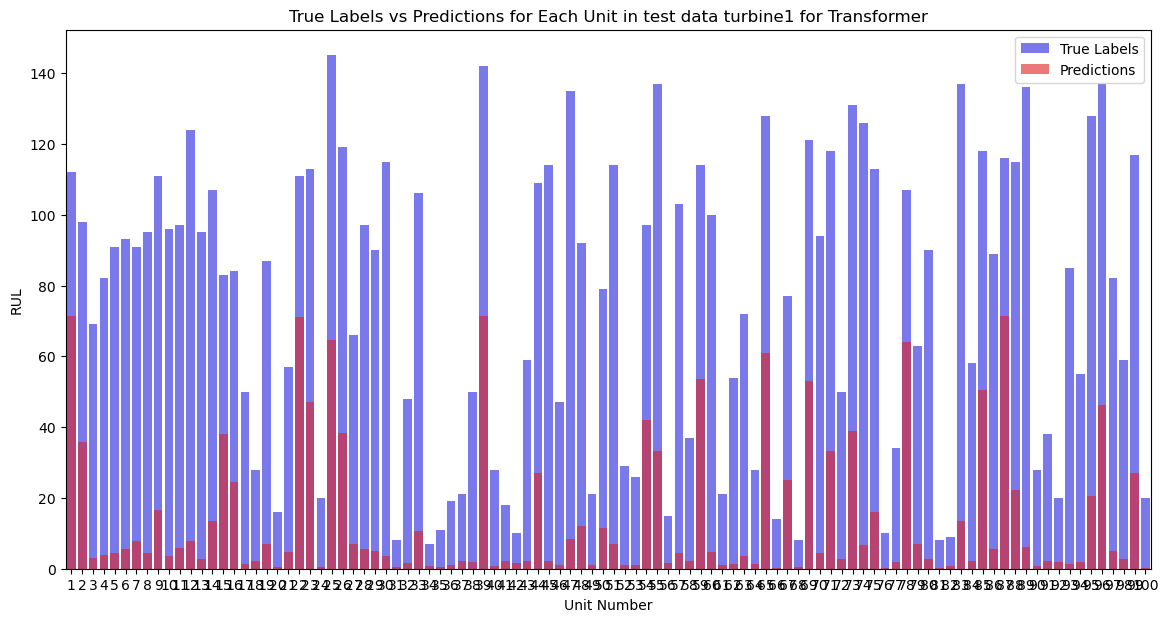

In [23]:
# Plot predictions vs true labels
units = range(1, len(pred_trans_t1) + 1)
t_df = pd.DataFrame({'Unit': units, 'True Label': true_trans_t1})
p_df = pd.DataFrame({'Unit': units, 'Prediction': pred_trans_t1})

plt.figure(figsize=(14, 7))
sns.barplot(x='Unit', y='True Label', data=t_df, color='blue', alpha=0.6, label='True Labels')
sns.barplot(x='Unit', y='Prediction', data=p_df, color='red', alpha=0.6, label='Predictions')
plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('True Labels vs Predictions for Each Unit in test data turbine1 for Transformer')
plt.legend()
plt.show()

## 3.3 Conclusion

For turbine 1, both the encoder-only model and the Transformer model encounter an issue during training where they get stuck at a loss of 27, indicating that they are trapped in a local minimum and cannot escape. Both models also show similar performance on the test set, with RMSE values of 59 and 61, respectively. These results are suboptimal but could be improved by incorporating more components from the paper on which we based our code.

Additionally, the encoder model predicts negative RUL values, which are nonsensical, whereas the Transformer model consistently predicts positive RUL values.

# 4. Turbine 2

## 4.1 Encoder

In [24]:
# Initialize the model
model = OnlyEncoder(d_model=24, dropout=dropout, nhead=nhead, nlayers=nlayers, max_len=max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) # From paper

# Train the model
loss_train_encoder_t2, loss_val_encoder_t2 = train_model(model, train_loader_t2, val_loader_t2, optimizer, criterion, scheduler, num_epochs, patience=patience, model_path='encoder_t2_best_model.pth')

Epoch 1 || Train Loss: 2249.05, Train RMSE: 58.65 || Validation Loss: 1235.39, Validation RMSE: 51.67
Epoch 2 || Train Loss: 1100.95, Train RMSE: 53.12 || Validation Loss: 579.43, Validation RMSE: 47.03
Epoch 3 || Train Loss: 537.19, Train RMSE: 49.05 || Validation Loss: 299.48, Validation RMSE: 44.57
Epoch 4 || Train Loss: 296.57, Train RMSE: 46.95 || Validation Loss: 180.64, Validation RMSE: 43.75
Epoch 5 || Train Loss: 193.51, Train RMSE: 46.19 || Validation Loss: 131.42, Validation RMSE: 43.82
Epoch 6 || Train Loss: 149.38, Train RMSE: 46.07 || Validation Loss: 114.79, Validation RMSE: 44.24
Epoch 7 || Train Loss: 135.35, Train RMSE: 46.29 || Validation Loss: 111.49, Validation RMSE: 44.64
Epoch 8 || Train Loss: 124.85, Train RMSE: 44.94 || Validation Loss: 100.88, Validation RMSE: 43.85
Epoch 9 || Train Loss: 102.96, Train RMSE: 42.71 || Validation Loss: 78.82, Validation RMSE: 41.15
Epoch 10 || Train Loss: 90.02, Train RMSE: 41.6 || Validation Loss: 68.94, Validation RMSE: 39.67


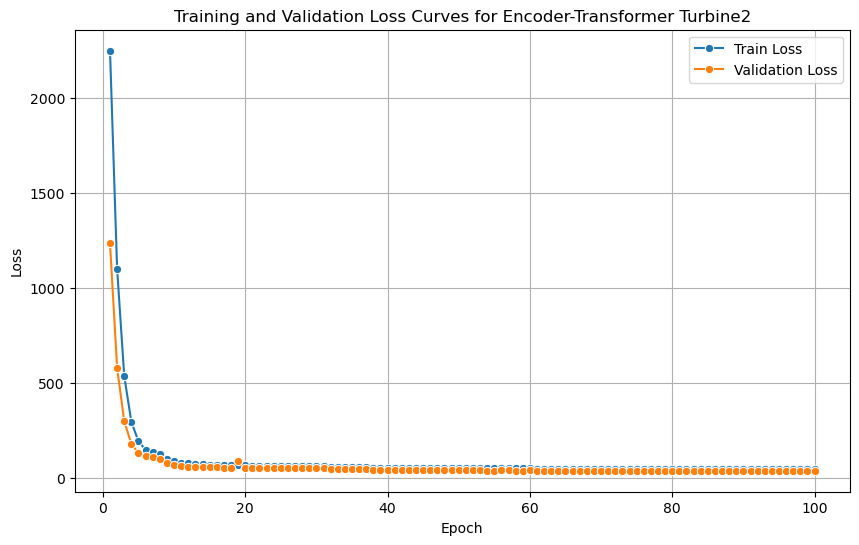

In [25]:
# Plot training
epochs = range(1, len(loss_train_encoder_t2[0]) + 1)

train_loss_df = pd.DataFrame({'Epoch': epochs, 'Train Loss': loss_train_encoder_t2[0]})
val_loss_df = pd.DataFrame({'Epoch': epochs, 'Val Loss': loss_val_encoder_t2[0]})

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_df, x='Epoch', y='Train Loss', marker='o', label='Train Loss')
sns.lineplot(data=val_loss_df, x='Epoch', y='Val Loss', marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Encoder-Transformer Turbine2')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Evaluate the model, load the best model
model = OnlyEncoder(d_model=24, dropout=dropout, nhead=nhead, nlayers=nlayers, max_len=max_len)
best_model_state_dict = torch.load('encoder_t2_best_model.pth')
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [27]:
pred_encoder_t2, true_encoder_t2 = inference(model, turbine2_test, turbine2_rul_test, window_size, sensor_features)

Test loss: 2158.0677931225896, Test RMSE: 42.50690545262517
Total time in testing 12.140721082687378


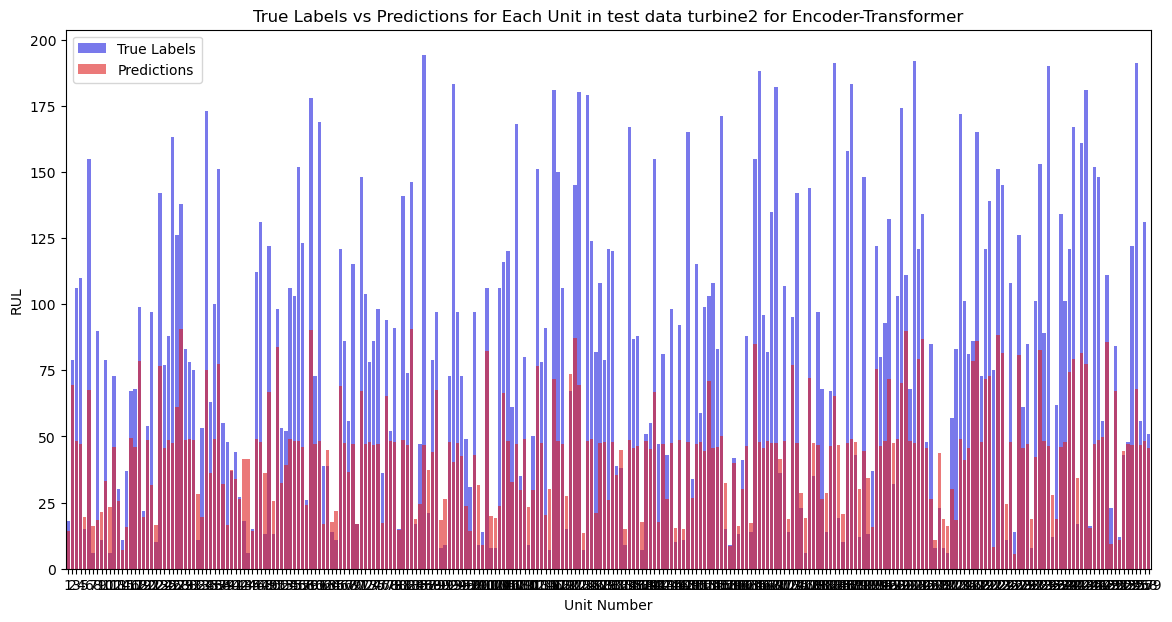

In [28]:
# Plot predictions vs true labels
units = range(1, len(pred_encoder_t2) + 1)
t_df = pd.DataFrame({'Unit': units, 'True Label': true_encoder_t2})
p_df = pd.DataFrame({'Unit': units, 'Prediction': pred_encoder_t2})

plt.figure(figsize=(14, 7))
sns.barplot(x='Unit', y='True Label', data=t_df, color='blue', alpha=0.6, label='True Labels')
sns.barplot(x='Unit', y='Prediction', data=p_df, color='red', alpha=0.6, label='Predictions')
plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('True Labels vs Predictions for Each Unit in test data turbine2 for Encoder-Transformer')
plt.legend()
plt.show()

## 4.2 Encoder-Decoder

In [29]:
# Initialize the model
model = TransformerModel(d_model=24, dropout=dropout, nhead=nhead, num_encoder_layers=num_encoder_layers, 
                         num_decoder_layers=num_decoder_layers, max_len=max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) # From paper

# Train the model
loss_train_trans_t2, loss_val_trans_t2 = train_model(model, train_loader_t2, val_loader_t2, optimizer, criterion, scheduler, num_epochs, patience=patience, model_path='transformer_t2_best_model.pth')

Epoch 1 || Train Loss: 1965.1, Train RMSE: 57.51 || Validation Loss: 1074.24, Validation RMSE: 50.68
Epoch 2 || Train Loss: 948.11, Train RMSE: 52.13 || Validation Loss: 490.86, Validation RMSE: 46.26
Epoch 3 || Train Loss: 451.79, Train RMSE: 48.33 || Validation Loss: 251.12, Validation RMSE: 44.18
Epoch 4 || Train Loss: 250.59, Train RMSE: 46.56 || Validation Loss: 155.77, Validation RMSE: 43.7
Epoch 5 || Train Loss: 169.11, Train RMSE: 46.08 || Validation Loss: 121.06, Validation RMSE: 44.0
Epoch 6 || Train Loss: 140.54, Train RMSE: 46.2 || Validation Loss: 112.2, Validation RMSE: 44.48
Epoch 7 || Train Loss: 130.32, Train RMSE: 45.68 || Validation Loss: 103.94, Validation RMSE: 44.03
Epoch 8 || Train Loss: 107.24, Train RMSE: 42.99 || Validation Loss: 85.33, Validation RMSE: 42.18
Epoch 9 || Train Loss: 93.4, Train RMSE: 41.83 || Validation Loss: 70.7, Validation RMSE: 39.98
Epoch 10 || Train Loss: 84.56, Train RMSE: 40.94 || Validation Loss: 64.35, Validation RMSE: 38.88
Epoch 11 

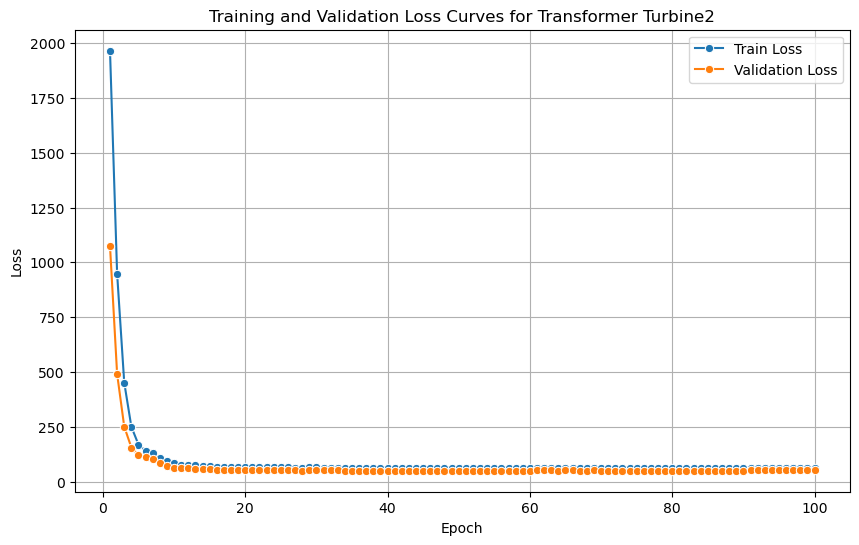

In [30]:
# Plot training
epochs = range(1, len(loss_train_trans_t2[0]) + 1)

train_loss_df = pd.DataFrame({'Epoch': epochs, 'Train Loss': loss_train_trans_t2[0]})
val_loss_df = pd.DataFrame({'Epoch': epochs, 'Val Loss': loss_val_trans_t2[0]})

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_df, x='Epoch', y='Train Loss', marker='o', label='Train Loss')
sns.lineplot(data=val_loss_df, x='Epoch', y='Val Loss', marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Transformer Turbine2')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Evaluate the model
model = TransformerModel(d_model=24, dropout=dropout, nhead=nhead, 
                         num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, max_len=max_len)
best_model_state_dict = torch.load('transformer_t2_best_model.pth')
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [32]:
pred_trans_t2, true_trans_t2 = inference(model, turbine2_test, turbine2_rul_test, window_size, sensor_features)

Test loss: 3508.5270427884284, Test RMSE: 47.119246729552515
Total time in testing 20.491358280181885


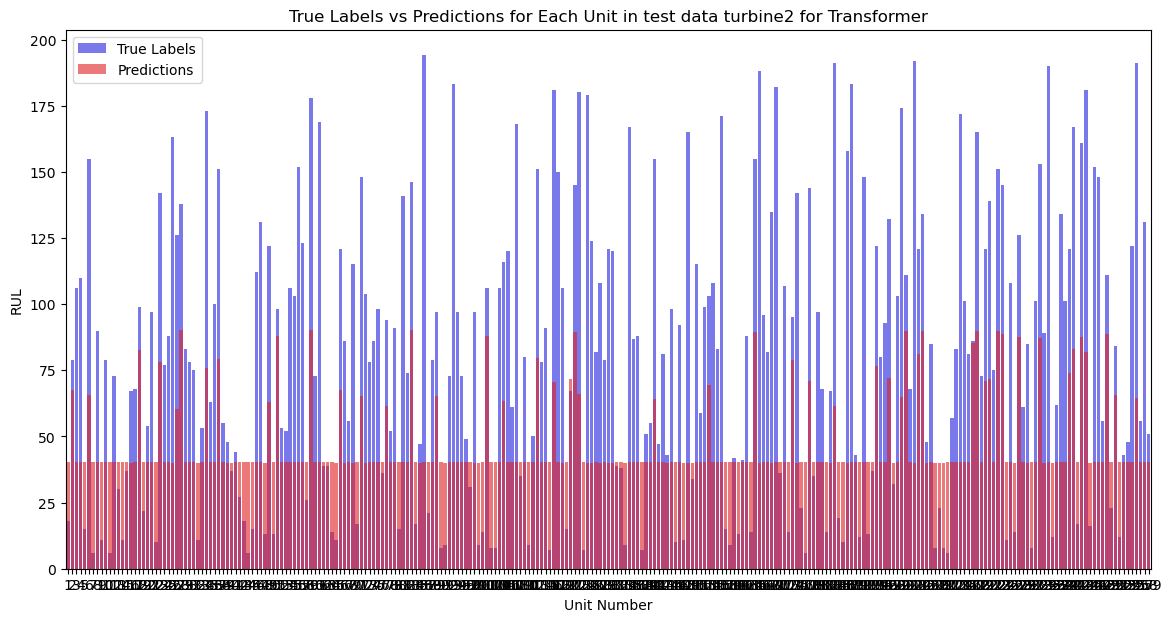

In [33]:
# Plot predictions vs true labels
units = range(1, len(pred_trans_t2) + 1)
t_df = pd.DataFrame({'Unit': units, 'True Label': true_trans_t2})
p_df = pd.DataFrame({'Unit': units, 'Prediction': pred_trans_t2})

plt.figure(figsize=(14, 7))
sns.barplot(x='Unit', y='True Label', data=t_df, color='blue', alpha=0.6, label='True Labels')
sns.barplot(x='Unit', y='Prediction', data=p_df, color='red', alpha=0.6, label='Predictions')
plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('True Labels vs Predictions for Each Unit in test data turbine2 for Transformer')
plt.legend()
plt.show()

## 4.3 Conclusion

This dataset presents more challenges. Both models get stuck at a loss of around 30, likely due to a local minimum. The encoder's predictions are significantly better than those of the Transformer model. The encoder provides more varied predictions and achieves a lower RMSE. In contrast, the Transformer model almost always predicts a constant value. This could be because the Transformer model has more parameters to train, and the available data isn't sufficient to properly fit the model, leading to underperformance.

# 5. Turbine 3

## 5.1 Encoder

In [34]:
# Initialize the model
model = OnlyEncoder(d_model=24, dropout=dropout, nhead=nhead, nlayers=nlayers, max_len=max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) # From paper

# Train the model
loss_train_encoder_t3, loss_val_encoder_t3 = train_model(model, train_loader_t3, val_loader_t3, optimizer, criterion, scheduler, num_epochs, patience=patience, model_path='encoder_t3_best_model.pth')

Epoch 1 || Train Loss: 5063.24, Train RMSE: 71.78 || Validation Loss: 3473.83, Validation RMSE: 66.09
Epoch 2 || Train Loss: 3765.78, Train RMSE: 68.95 || Validation Loss: 2450.72, Validation RMSE: 63.07
Epoch 3 || Train Loss: 2585.97, Train RMSE: 65.68 || Validation Loss: 1647.34, Validation RMSE: 59.97
Epoch 4 || Train Loss: 1743.41, Train RMSE: 62.61 || Validation Loss: 1115.08, Validation RMSE: 57.3
Epoch 5 || Train Loss: 1195.24, Train RMSE: 60.03 || Validation Loss: 773.05, Validation RMSE: 55.15
Epoch 6 || Train Loss: 842.19, Train RMSE: 57.94 || Validation Loss: 554.63, Validation RMSE: 53.5
Epoch 7 || Train Loss: 616.1, Train RMSE: 56.33 || Validation Loss: 411.59, Validation RMSE: 52.25
Epoch 8 || Train Loss: 466.32, Train RMSE: 55.1 || Validation Loss: 317.04, Validation RMSE: 51.33
Epoch 9 || Train Loss: 364.63, Train RMSE: 54.16 || Validation Loss: 253.72, Validation RMSE: 50.68
Epoch 10 || Train Loss: 295.91, Train RMSE: 53.43 || Validation Loss: 211.77, Validation RMSE: 

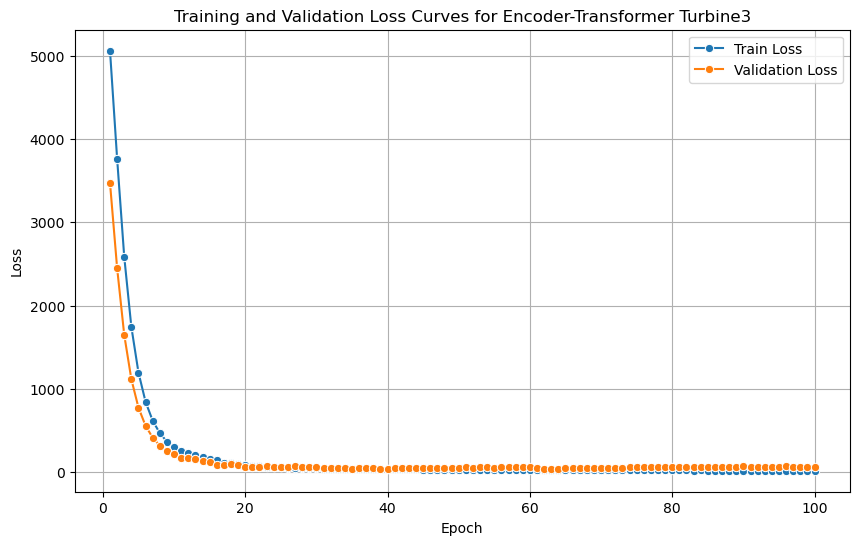

In [35]:
# Plot training
epochs = range(1, len(loss_train_encoder_t3[0]) + 1)

train_loss_df = pd.DataFrame({'Epoch': epochs, 'Train Loss': loss_train_encoder_t3[0]})
val_loss_df = pd.DataFrame({'Epoch': epochs, 'Val Loss': loss_val_encoder_t3[0]})

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_df, x='Epoch', y='Train Loss', marker='o', label='Train Loss')
sns.lineplot(data=val_loss_df, x='Epoch', y='Val Loss', marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Encoder-Transformer Turbine3')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Evaluate the model, load the best model
model = OnlyEncoder(d_model=24, dropout=dropout, nhead=nhead, nlayers=nlayers, max_len=max_len)
best_model_state_dict = torch.load('encoder_t3_best_model.pth')
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [37]:
pred_encoder_t3, true_encoder_t3 = inference(model, turbine3_test, turbine3_rul_test, window_size, sensor_features)

Test loss: 1276.5797905766965, Test RMSE: 56.445621757507325
Total time in testing 4.718014240264893


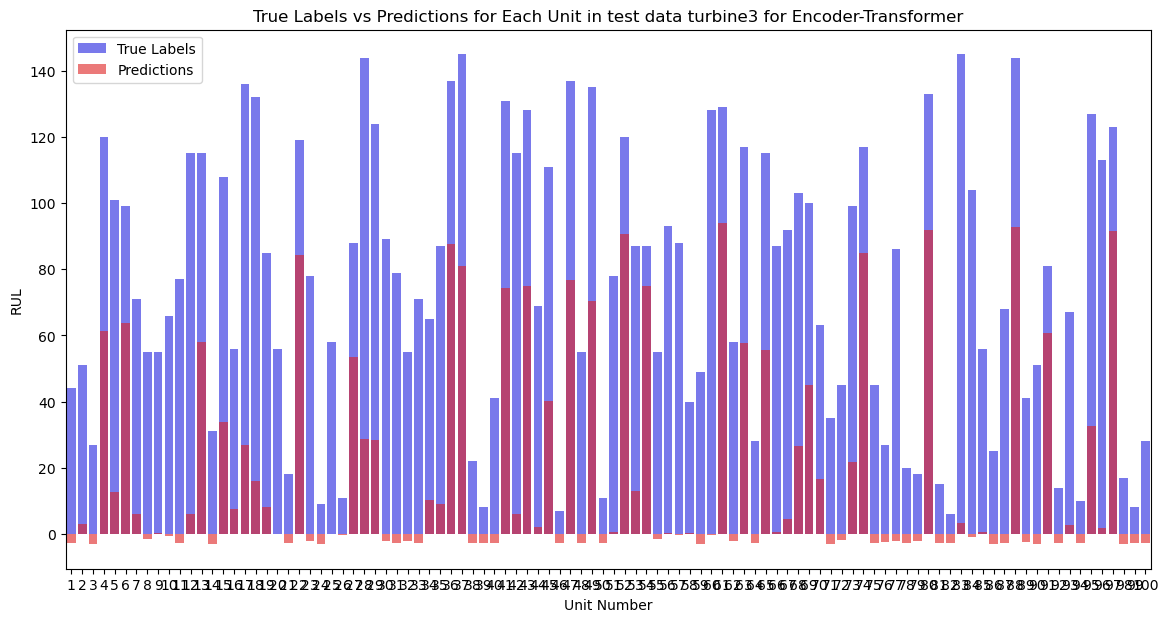

In [38]:
# Plot predictions vs true labels
units = range(1, len(pred_encoder_t3) + 1)
t_df = pd.DataFrame({'Unit': units, 'True Label': true_encoder_t3})
p_df = pd.DataFrame({'Unit': units, 'Prediction': pred_encoder_t3})

plt.figure(figsize=(14, 7))
sns.barplot(x='Unit', y='True Label', data=t_df, color='blue', alpha=0.6, label='True Labels')
sns.barplot(x='Unit', y='Prediction', data=p_df, color='red', alpha=0.6, label='Predictions')
plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('True Labels vs Predictions for Each Unit in test data turbine3 for Encoder-Transformer')
plt.legend()
plt.show()

## 5.2 Encoder-Decoder

In [39]:
# Initialize the model
model = TransformerModel(d_model=24, dropout=dropout, nhead=nhead, num_encoder_layers=num_encoder_layers, 
                         num_decoder_layers=num_decoder_layers, max_len=max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) # From paper

# Train the model
loss_train_trans_t3, loss_val_trans_t3 = train_model(model, train_loader_t3, val_loader_t3, optimizer, criterion, scheduler, num_epochs, patience=patience, model_path='transformer_t3_best_model.pth')

Epoch 1 || Train Loss: 4546.0, Train RMSE: 70.76 || Validation Loss: 3112.33, Validation RMSE: 65.11
Epoch 2 || Train Loss: 3390.07, Train RMSE: 68.03 || Validation Loss: 2207.82, Validation RMSE: 62.21
Epoch 3 || Train Loss: 2331.79, Train RMSE: 64.84 || Validation Loss: 1482.4, Validation RMSE: 59.21
Epoch 4 || Train Loss: 1559.86, Train RMSE: 61.81 || Validation Loss: 993.08, Validation RMSE: 56.58
Epoch 5 || Train Loss: 1060.74, Train RMSE: 59.26 || Validation Loss: 683.43, Validation RMSE: 54.5
Epoch 6 || Train Loss: 746.22, Train RMSE: 57.3 || Validation Loss: 487.82, Validation RMSE: 52.93
Epoch 7 || Train Loss: 539.38, Train RMSE: 55.74 || Validation Loss: 362.66, Validation RMSE: 51.78
Epoch 8 || Train Loss: 410.27, Train RMSE: 54.59 || Validation Loss: 280.51, Validation RMSE: 50.96
Epoch 9 || Train Loss: 323.0, Train RMSE: 53.73 || Validation Loss: 227.47, Validation RMSE: 50.4
Epoch 10 || Train Loss: 266.25, Train RMSE: 53.15 || Validation Loss: 193.39, Validation RMSE: 50.

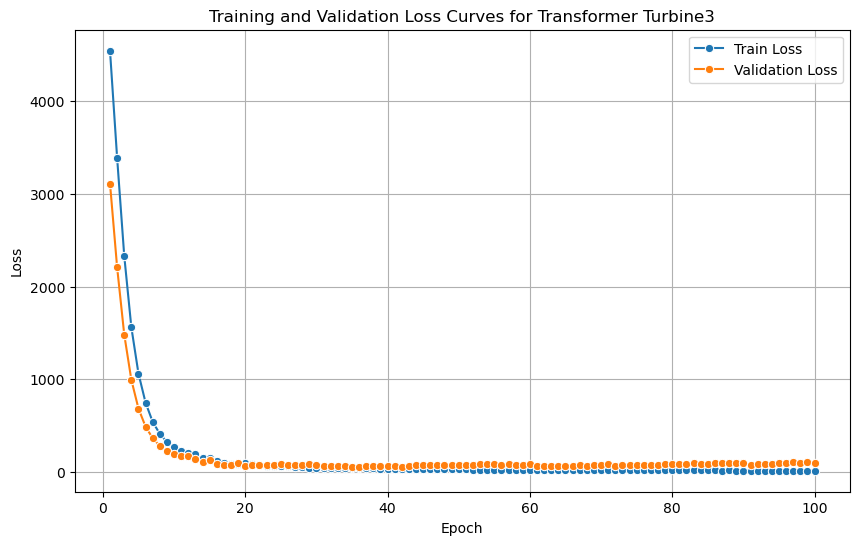

In [40]:
# Plot training
epochs = range(1, len(loss_train_trans_t3[0]) + 1)

train_loss_df = pd.DataFrame({'Epoch': epochs, 'Train Loss': loss_train_trans_t3[0]})
val_loss_df = pd.DataFrame({'Epoch': epochs, 'Val Loss': loss_val_trans_t3[0]})

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_df, x='Epoch', y='Train Loss', marker='o', label='Train Loss')
sns.lineplot(data=val_loss_df, x='Epoch', y='Val Loss', marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Transformer Turbine3')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Evaluate the model
model = TransformerModel(d_model=24, dropout=dropout, nhead=nhead, 
                         num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, max_len=max_len)
best_model_state_dict = torch.load('transformer_t3_best_model.pth')
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [42]:
pred_trans_t3, true_trans_t3 = inference(model, turbine3_test, turbine3_rul_test, window_size, sensor_features)

Test loss: 722.0276818001271, Test RMSE: 54.424624595642086
Total time in testing 7.92313814163208


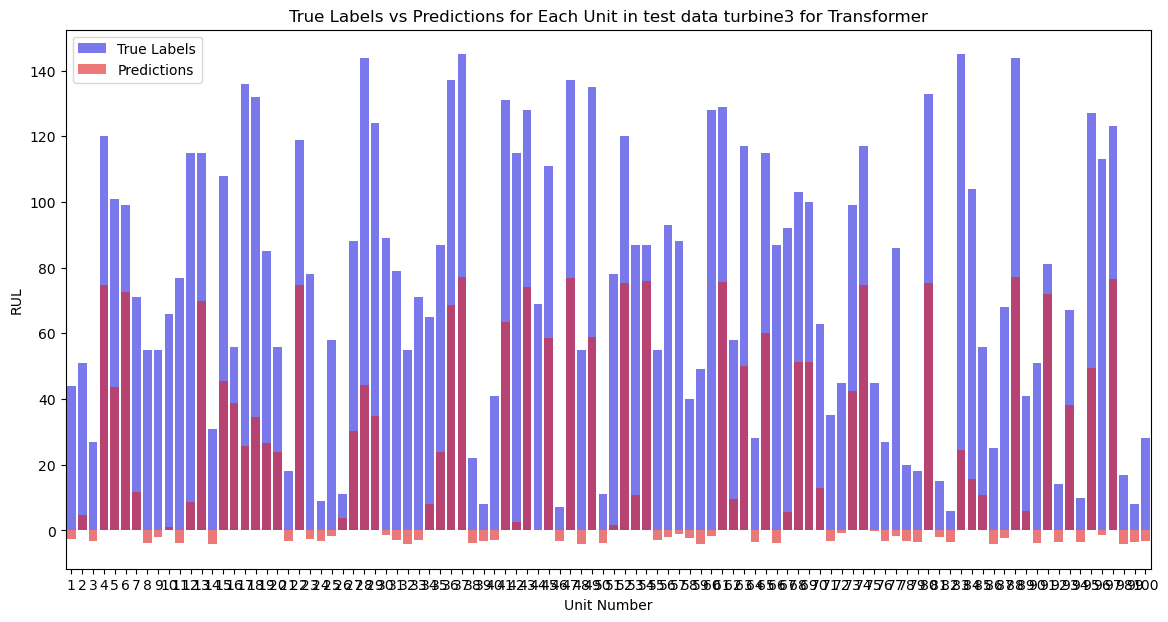

In [43]:
# Plot predictions vs true labels
units = range(1, len(pred_trans_t3) + 1)
t_df = pd.DataFrame({'Unit': units, 'True Label': true_trans_t3})
p_df = pd.DataFrame({'Unit': units, 'Prediction': pred_trans_t3})

plt.figure(figsize=(14, 7))
sns.barplot(x='Unit', y='True Label', data=t_df, color='blue', alpha=0.6, label='True Labels')
sns.barplot(x='Unit', y='Prediction', data=p_df, color='red', alpha=0.6, label='Predictions')
plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('True Labels vs Predictions for Each Unit in test data turbine3 for Transformer')
plt.legend()
plt.show()

## 5.3 Conclusion

With turbine 3, we observe similar behavior as with turbine 1 due to their similarities. Both the encoder-only model and the Transformer model get stuck at a similar loss value of 24, indicating they are trapped in a local minimum.

The predictions are also suboptimal. The encoder model reaches an RMSE of 56 on the test dataset, while the Transformer model achieves an RMSE of 54. Both models produce negative RUL predictions, which are nonsensical.

# 6. Turbine 4

## 6.1 Encoder

In [44]:
# Initialize the model
model = OnlyEncoder(d_model=24, dropout=dropout, nhead=nhead, nlayers=nlayers, max_len=max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) # From paper

# Train the model
loss_train_encoder_t4, loss_val_encoder_t4 = train_model(model, train_loader_t4, val_loader_t4, optimizer, criterion, scheduler, num_epochs, patience=patience, model_path='encoder_t4_best_model.pth')

Epoch 1 || Train Loss: 3878.66, Train RMSE: 68.73 || Validation Loss: 2285.9, Validation RMSE: 63.87
Epoch 2 || Train Loss: 1553.35, Train RMSE: 61.26 || Validation Loss: 878.45, Validation RMSE: 57.3
Epoch 3 || Train Loss: 647.81, Train RMSE: 56.16 || Validation Loss: 408.12, Validation RMSE: 53.68
Epoch 4 || Train Loss: 333.65, Train RMSE: 53.52 || Validation Loss: 239.52, Validation RMSE: 51.99
Epoch 5 || Train Loss: 220.15, Train RMSE: 52.35 || Validation Loss: 179.89, Validation RMSE: 51.32
Epoch 6 || Train Loss: 182.87, Train RMSE: 51.93 || Validation Loss: 163.53, Validation RMSE: 51.14
Epoch 7 || Train Loss: 173.67, Train RMSE: 51.79 || Validation Loss: 158.07, Validation RMSE: 50.92
Epoch 8 || Train Loss: 166.57, Train RMSE: 51.19 || Validation Loss: 143.73, Validation RMSE: 49.68
Epoch 9 || Train Loss: 151.44, Train RMSE: 50.03 || Validation Loss: 131.72, Validation RMSE: 48.64
Epoch 10 || Train Loss: 138.77, Train RMSE: 49.01 || Validation Loss: 122.61, Validation RMSE: 47.7

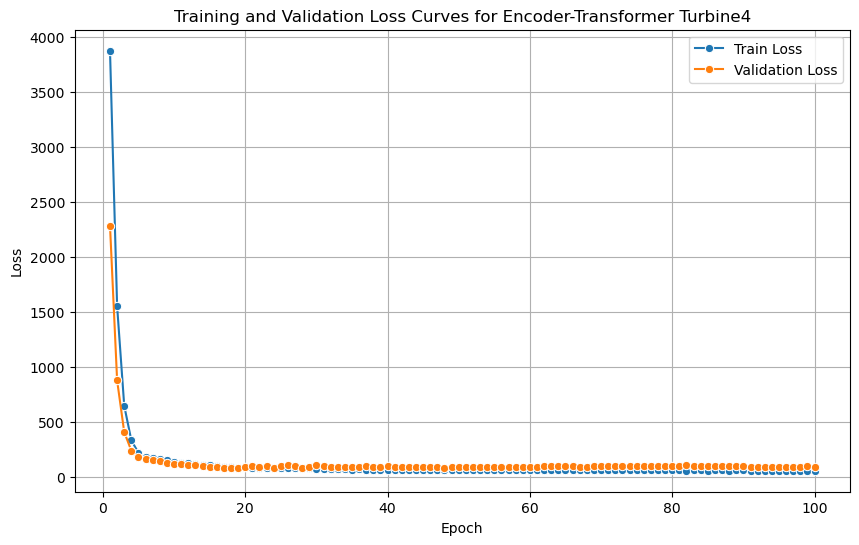

In [45]:
# Plot training
epochs = range(1, len(loss_train_encoder_t4[0]) + 1)

train_loss_df = pd.DataFrame({'Epoch': epochs, 'Train Loss': loss_train_encoder_t4[0]})
val_loss_df = pd.DataFrame({'Epoch': epochs, 'Val Loss': loss_val_encoder_t4[0]})

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_df, x='Epoch', y='Train Loss', marker='o', label='Train Loss')
sns.lineplot(data=val_loss_df, x='Epoch', y='Val Loss', marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Encoder-Transformer Turbine4')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# Evaluate the model, load the best model
model = OnlyEncoder(d_model=24, dropout=dropout, nhead=nhead, nlayers=nlayers, max_len=max_len)
best_model_state_dict = torch.load('encoder_t4_best_model.pth')
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [47]:
pred_encoder_t4, true_encoder_t4 = inference(model, turbine4_test, turbine4_rul_test, window_size, sensor_features)

Test loss: 4764.611708315149, Test RMSE: 53.68242761012046
Total time in testing 12.002718925476074


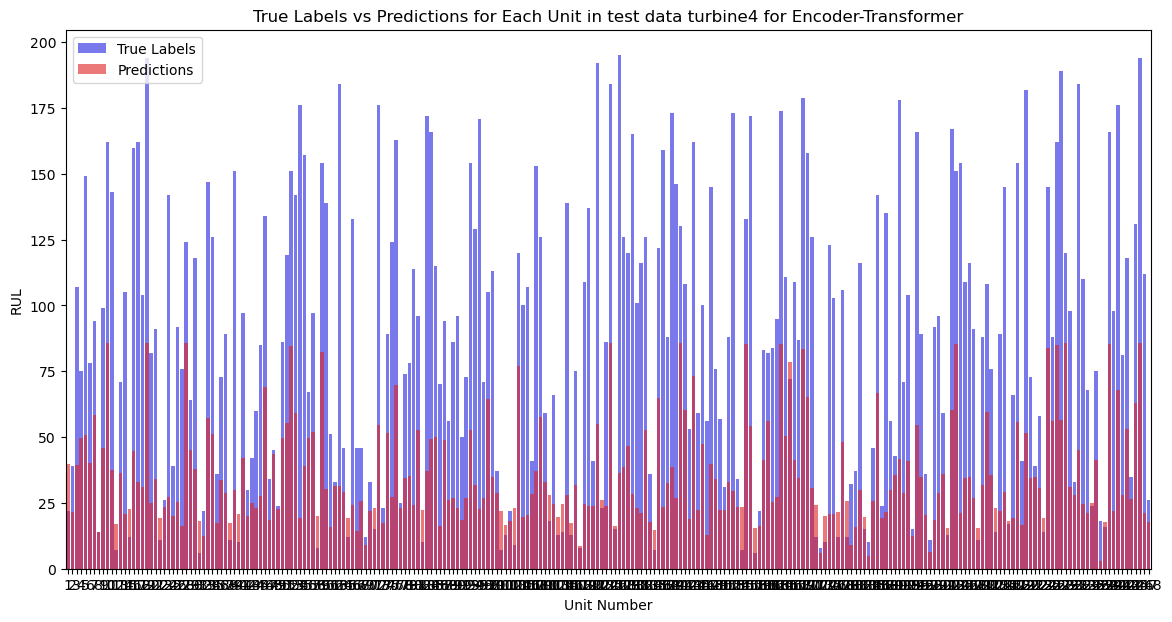

In [48]:
# Plot predictions vs true labels
units = range(1, len(pred_encoder_t4) + 1)
t_df = pd.DataFrame({'Unit': units, 'True Label': true_encoder_t4})
p_df = pd.DataFrame({'Unit': units, 'Prediction': pred_encoder_t4})

plt.figure(figsize=(14, 7))
sns.barplot(x='Unit', y='True Label', data=t_df, color='blue', alpha=0.6, label='True Labels')
sns.barplot(x='Unit', y='Prediction', data=p_df, color='red', alpha=0.6, label='Predictions')
plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('True Labels vs Predictions for Each Unit in test data turbine4 for Encoder-Transformer')
plt.legend()
plt.show()

## 6.2 Encoder-Decoder

In [49]:
# Initialize the model
model = TransformerModel(d_model=24, dropout=dropout, nhead=nhead, num_encoder_layers=num_encoder_layers, 
                         num_decoder_layers=num_decoder_layers, max_len=max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5) # From paper

# Train the model
loss_train_trans_t4, loss_val_trans_t4 = train_model(model, train_loader_t4, val_loader_t4, optimizer, criterion, scheduler, num_epochs, patience=patience, model_path='transformer_t4_best_model.pth')

Epoch 1 || Train Loss: 3528.82, Train RMSE: 67.87 || Validation Loss: 2061.95, Validation RMSE: 63.06
Epoch 2 || Train Loss: 1387.15, Train RMSE: 60.48 || Validation Loss: 775.09, Validation RMSE: 56.61
Epoch 3 || Train Loss: 570.45, Train RMSE: 55.56 || Validation Loss: 361.04, Validation RMSE: 53.24
Epoch 4 || Train Loss: 299.24, Train RMSE: 53.18 || Validation Loss: 218.06, Validation RMSE: 51.75
Epoch 5 || Train Loss: 206.45, Train RMSE: 52.23 || Validation Loss: 172.19, Validation RMSE: 51.24
Epoch 6 || Train Loss: 178.16, Train RMSE: 51.86 || Validation Loss: 162.02, Validation RMSE: 51.13
Epoch 7 || Train Loss: 173.18, Train RMSE: 51.77 || Validation Loss: 158.5, Validation RMSE: 50.95
Epoch 8 || Train Loss: 168.49, Train RMSE: 51.34 || Validation Loss: 145.49, Validation RMSE: 49.88
Epoch 9 || Train Loss: 149.83, Train RMSE: 49.9 || Validation Loss: 131.44, Validation RMSE: 48.66
Epoch 10 || Train Loss: 137.28, Train RMSE: 48.85 || Validation Loss: 122.99, Validation RMSE: 47.8

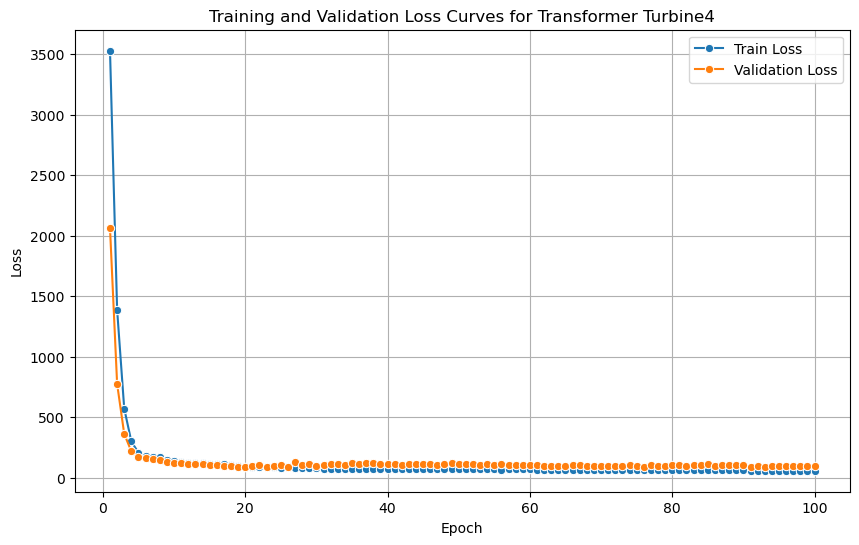

In [50]:
# Plot training
epochs = range(1, len(loss_train_trans_t4[0]) + 1)

train_loss_df = pd.DataFrame({'Epoch': epochs, 'Train Loss': loss_train_trans_t4[0]})
val_loss_df = pd.DataFrame({'Epoch': epochs, 'Val Loss': loss_val_trans_t4[0]})

plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_df, x='Epoch', y='Train Loss', marker='o', label='Train Loss')
sns.lineplot(data=val_loss_df, x='Epoch', y='Val Loss', marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Transformer Turbine4')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Evaluate the model
model = TransformerModel(d_model=24, dropout=dropout, nhead=nhead, 
                         num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, max_len=max_len)
best_model_state_dict = torch.load('transformer_t4_best_model.pth')
model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [52]:
pred_trans_t4, true_trans_t4 = inference(model, turbine4_test, turbine4_rul_test, window_size, sensor_features)

Test loss: 1277.8742621685228, Test RMSE: 46.008117937272594
Total time in testing 17.53682541847229


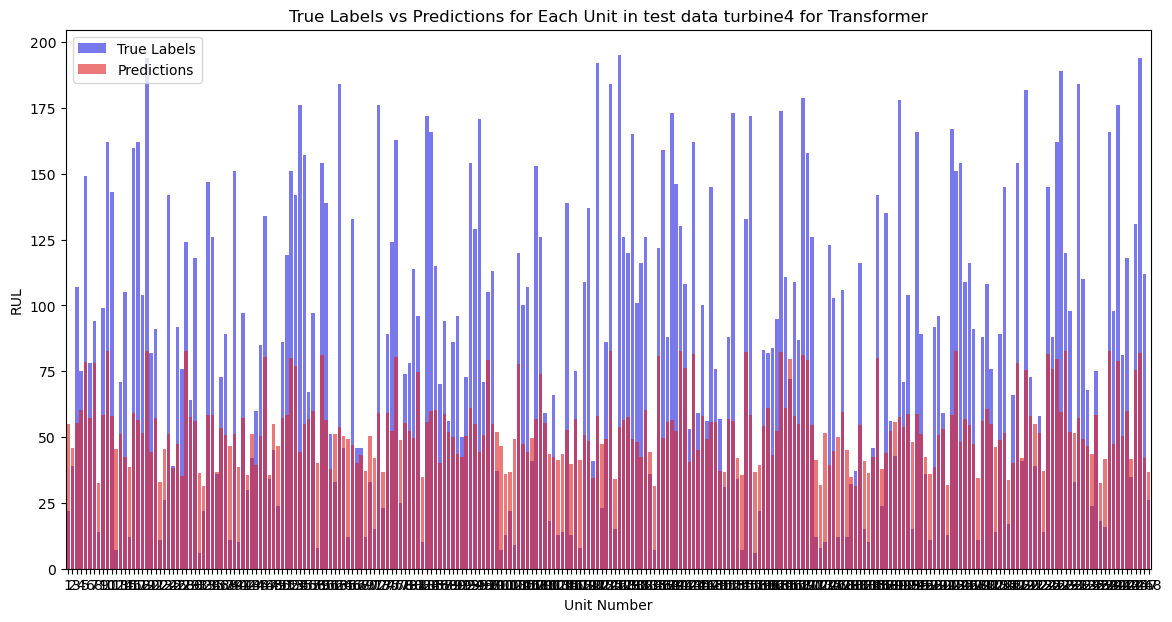

In [53]:
# Plot predictions vs true labels
units = range(1, len(pred_trans_t4) + 1)
t_df = pd.DataFrame({'Unit': units, 'True Label': true_trans_t4})
p_df = pd.DataFrame({'Unit': units, 'Prediction': pred_trans_t4})

plt.figure(figsize=(14, 7))
sns.barplot(x='Unit', y='True Label', data=t_df, color='blue', alpha=0.6, label='True Labels')
sns.barplot(x='Unit', y='Prediction', data=p_df, color='red', alpha=0.6, label='Predictions')
plt.xlabel('Unit Number')
plt.ylabel('RUL')
plt.title('True Labels vs Predictions for Each Unit in test data turbine4 for Transformer')
plt.legend()
plt.show()

## 6.3 Conclusion

The turbine 4 dataset resembles the turbine 2 dataset, making it challenging to predict due to its highly random nature. Both models encounter difficulty during training, getting stuck at a loss value of 34, suggesting they are trapped in a local minimum.

In terms of performance, the encoder model achieves an RMSE of 59 on the test data. While the predictions appear out of scale, they generally follow the trend of the data. On the other hand, the Transformer model outperforms the encoder model with an RMSE of 46. This improvement may be attributed to the complexity of the dataset, which could be too challenging for a simple encoder model. The predictions of the Transformer model appear reasonable, although they do not precisely match the true labels, they do exhibit a discernible trend.

# 7. Main Takeaways

The main conclusions drawn from our analysis are as follows:
- The models are underperforming, indicating they suffer from underfitting.
- The simplicity of the models prevents them from capturing the underlying information present in the data.
- While the predictions are generally poor, they still manage to capture some of the trend exhibited by the true labels.
- Despite using the hyperparameters specified in the original paper, our models fail to achieve satisfactory performance, likely due to their smaller size compared to the models in the paper.

Moving forward, several future tasks can be undertaken to enhance performance:
- The models are struggling and often get stuck in local minima during training. Manual attempts at hyperparameter tuning might help the models escape these local minima and continue training. However, conducting a grid search for all eight models is computationally expensive and time-consuming.
- Increasing the complexity of the models could potentially improve performance. However, this would also significantly increase training time, which is already substantial for the eight models we are training.
- To address the underperforming models, implementing the discriminator components as described in the paper could be the most effective solution. These discriminators would aid in capturing crucial information about the data, leading to improved predictions in both the feature and domain spaces. Additionally, it's essential to utilize the same loss function (Binary Cross Entropy) and optimizer (Stochastic Gradient Descent) as specified in the paper for optimal performance.